In [126]:
# --------------------------------------------------------------------------------------
#                        SPICE REMOVE CONTAMINATION SCRIPT
#               Removes anomalies and outliers from the error-free CFA data
#
#    - Loads raw, unfiltered CFA with depth corrections. Gets CPP and particle conc.
#    - Reads CFA dataframe (with mechanical errors removed)
#    - Calculates CPP and particle conc. for the full core and the Holocene
#    - Counts and NaNs all rows with a 'hump-shaped' PSD anomaly
#    - Creates outlier removal scenarios
#    - Preserves known dust events during 'hump' and outlier removal
#    - Creates a series of plots to evaluate different outlier removal scenarios
#    - Creates before & after plots for the data processing
#
# Katie Anderson, 7/10/19
# ---------------------------------------------------------------------------------------

In [127]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import csv
import os
from datetime import date
import matplotlib.pyplot as plt
import statistics

# Go into the correct directory- this is a personal desktop folder that backs up to OneDrive
os.chdir('C:\\Users\\katie\\OneDrive\\Documents\\SPICE\\Scripts')

# Run mechanical error cleaning script. Can run all 3 scripts from one location here when this is finished.
#%run "Phase 1 SPICE Error Removal.ipynb"

# Run function definitions script
%run "SPICE Data Processing Functions.ipynb"

In [128]:
# ----------ORIGINAL CFA DATA PREP--------------------------#
# THIS IS ONLY FOR MAKING BEFORE/AFTER PLOTS

# Get concentrations and CPP (before filtering) for plotting

# Load Matlab raw, unfiltered CFA file
mat = loadmat('../Data/CFA_FullCore_Unfiltered.mat')
# Import main variable from Matlab file
mdata = mat['K']
# Create dataframe and add 1st column
original_cfa = pd.DataFrame({'Depth (m)':mdata[:,0]})
# Add remaining columns and data to the dataframe
original_cfa['Flow Rate'] = mdata[:,1]
original_cfa['ECM'] = mdata[:,2]
original_cfa['1'] = mdata[:,3]
original_cfa['1.1'] = mdata[:,4]
original_cfa['1.2'] = mdata[:,5]
original_cfa['1.3'] = mdata[:,6]
original_cfa['1.4'] = mdata[:,7]
original_cfa['1.5'] = mdata[:,8]
original_cfa['1.6'] = mdata[:,9]
original_cfa['1.7'] = mdata[:,10]
original_cfa['1.8'] = mdata[:,11]
original_cfa['1.9'] = mdata[:,12]
original_cfa['2']   = mdata[:,13]
original_cfa['2.1'] = mdata[:,14]
original_cfa['2.2'] = mdata[:,15]
original_cfa['2.3'] = mdata[:,16]
original_cfa['2.4'] = mdata[:,17]
original_cfa['2.5'] = mdata[:,18]
original_cfa['2.7'] = mdata[:,19]
original_cfa['2.9'] = mdata[:,20]
original_cfa['3.2'] = mdata[:,21]
original_cfa['3.6'] = mdata[:,22]
original_cfa['4']   = mdata[:,23]
original_cfa['4.5'] = mdata[:,24]
original_cfa['5.1'] = mdata[:,25]
original_cfa['5.7'] = mdata[:,26]
original_cfa['6.4'] = mdata[:,27]
original_cfa['7.2'] = mdata[:,28]
original_cfa['8.1'] = mdata[:,29]
original_cfa['9']   = mdata[:,30]
original_cfa['10']  = mdata[:,31]
original_cfa['12']  = mdata[:,32]

# Load Matlab file with most updated CFA depths
mat = loadmat('../Data/FinalCFA_1751_Fullcore.mat')
mdata = mat['FinalCFA']
# Create dataframe and add 1st column
cfa_newDepths = pd.DataFrame({'Depth (m)':mdata[:,0]})

# Make a column with the original depths
original_cfa['Original Depth (m)'] = original_cfa['Depth (m)']
# Copy updated depths into unfiltered CFA depths
original_cfa['Depth (m)'] = cfa_newDepths['Depth (m)']

# Get original particle concentrations for plotting later
sum_columns = ['1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', 
               '1.9', '2', '2.1', '2.2', '2.3', '2.4', '2.5', '2.7', '2.9',
               '3.2', '3.6', '4', '4.5', '5.1', '5.7', '6.4', '7.2', '8.1', 
               '9', '10']
original_sums = original_cfa[sum_columns].sum(axis = 1)

# Get original CPP for plotting later
original_cfa['CPP'] = find_cpp(original_cfa)

-->Use smallest and largest bins for CPP? Enter Y or N: n
CPP function found negative sum of all particles.
CPP function found negative sum of coarse particles.


In [129]:
# --------------------CFA FILE PREP--------------------------#

# Load complete CFA file after mechanical error removal
cfa = pd.read_csv('../Data/Cleaned_CFA_Phase1_2019-07-10.csv', header = 0) 
del cfa['Unnamed: 0']
# Get a copy of only the Holocene data, for outlier comparisons
cfa_holocene = cfa.loc[0:214959, :].copy()

# Load depths of real dust events
dust_events = pd.read_excel('../Data/Dust Events.xlsx')
# Only keep the columns with the depth ranges
dust_events = dust_events.loc[:, 'Dust Event Start (m)':'Dust Event End (m)'].copy()

# Label all rows during known dust events
# Add Y/N 'Dust Event?' column. Default to false.
cfa['Dust Event?'] = False
# Get the row indices of all measurements within dust events
dust_rows = label_dust_events(cfa, dust_events)
# Change all 'Dust Event?' values in those rows to True
cfa.loc[dust_rows, 'Dust Event?'] = True

In [131]:
# ----------------------------------------------------------------------------
#                                        PART 2:
#                        CFA DATA OUTLIER & CONTAMINATION REMOVAL
# ----------------------------------------------------------------------------

original_length = 438217 # From the last script
holocene_length = 214960
print('CFA dataset length after error removal:', original_length)

# 1) Identify and remove hump-shaped PSD anomalies

# Add CPP column to CFA dataframe. Function will ask to include/exclude bins 1 and 12
cfa['CPP'] = find_cpp(cfa)
# Do this for the Holocene-only dataframe too
cfa_holocene['CPP'] = find_cpp(cfa_holocene)

# Find humps for all CFA depths
print('\nPSD hump anomalies-- Full core')
humps = find_humps(cfa, 0, 1752)
print('\nPSD hump anomalies-- Holocene')
humps_holocene = find_humps(cfa_holocene, 0, 1752)

# PRESERVE KNOWN DUST EVENTS
# Remove all rows in real dust events from the hump list
bad_rows = humps.index.difference(dust_rows)

# NaN values in remaining rows, except boolean columns
cfa.loc[bad_rows, 'Depth (m)': 'Original Depth (m)'] = np.nan
cfa.loc[bad_rows, 'Age b 1950'] = np.nan
cfa.loc[bad_rows, 'CPP'] = np.nan

bad_rows = humps_holocene.index.difference(dust_rows)
# NaN values in remaining rows, except boolean columns
cfa_holocene.loc[bad_rows, 'Depth (m)':'Original Depth (m)'] = np.nan
cfa_holocene.loc[bad_rows, 'Age b 1950'] = np.nan
cfa_holocene.loc[bad_rows, 'CPP'] = np.nan

# 2) Identify and remove particle concentration & CPP outliers
# Get particle concentrations
# Change this if we decide to include smallest & largest bins
sum_columns = ['1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', 
               '1.9', '2', '2.1', '2.2', '2.3', '2.4', '2.5', '2.7', '2.9',
               '3.2', '3.6', '4', '4.5', '5.1', '5.7', '6.4', '7.2', '8.1', 
               '9', '10']
# Set skipna to False, otherwise, rows with all NaNs will sum to 0
cfa['Sum 1.1-10']          = cfa[sum_columns].sum(axis = 1, skipna = False)
cfa_holocene['Sum 1.1-10'] = cfa_holocene[sum_columns].sum(axis = 1, skipna = False)

CFA dataset length after error removal: 438217
-->Use smallest and largest bins for CPP? Enter Y or N: n
-->Use smallest and largest bins for CPP? Enter Y or N: n

PSD hump anomalies-- Full core
Number of measurements:     3631
Number of discrete events:  617

PSD hump anomalies-- Holocene
Number of measurements:     2888
Number of discrete events:  382


In [ ]:
# EVERYTHING BELOW IS A WORK IN PROGRESS

In [13]:
# Create different scenarios for outlier removal

# Set values for # of measurements to use to determine background levels
window1 = 500
#window2 = 100
#window3 = 1000
# Set threshold # of standard deviations from the background levels
stdev1  = 2
#stdev2  = 3

# Make another copy of the CFA data to keep it from being affected by the function
# Make as many copies as there are scenarios, to be sure that each scenario is 100% its own
#test_cfa1 = cfa_holocene.copy()
#test_cfa2 = cfa_holocene.copy()
#test_cfa3 = cfa_holocene.copy()
#test_cfa4 = cfa_holocene.copy()
#test_cfa5 = cfa_holocene.copy()
#test_cfa6 = cfa_holocene.copy()

# Call function to create new dataframes sans outliers
# Inputs: CFA dataframe, # of measurements to use for background, threshold # of standard deviations
#scenario1 = test_threshold(test_cfa1, window1, stdev1)
#scenario2 = test_threshold(test_cfa2, window2, stdev1)
#scenario3 = test_threshold(test_cfa3, window3, stdev1)

#scenario4 = test_threshold(test_cfa4, window1, stdev2)
#scenario5 = test_threshold(test_cfa5, window2, stdev2)
#scenario6 = test_threshold(test_cfa6, window3, stdev2)

In [16]:
# Create different scenarios for outlier removal in the deep core

window = 100
stdev = 2

scenario = test_threshold(cfa, window, stdev)


NEW OUTLIER REMOVAL SCENARIO

-->Print outlier counts? Enter Y or N: y

Conc. outliers:               178103
CPP outliers:                 191510
Overlap:                      54619

Conc. outliers w/in volcanic event: 74704
CPP outliers w/in volcanic event:   70958
Overlap w/in volcanic event:        22416

-->Remove outliers at volcanic events? Enter Y or N: y

SUMMARY OF OUTLIER REMOVAL
1) Rows Removed:  54619
2) Number of discrete volcanic events in removed rows: 497
3) Number of discrete core breaks in removed rows:     378


In [35]:
scenario.loc[335505:335509, :]

,Depth (m),Flow Rate,ECM,1,1.1,1.2,1.3,1.4,1.5,1.6,...,8.1,9,10,12,Original Depth (m),Break?,New Break?,Age b 1950,CPP,Sum 1.1-10
335505,1275.305908,91.6,1.80,460.89957,198.53413,106.07261,87.017088,67.116740,68.149305,51.252783,...,0.187739,0.187739,0.187739,0.750957,1275.3060,False,False,30233.972292,3.241585,1132.254705
335506,1275.310905,78.4,1.82,516.58714,215.15293,114.56481,95.855857,76.266486,69.113064,50.954377,...,0.550263,0.110053,0.000000,1.210579,1275.3110,False,False,30234.244099,3.272924,1220.593934
335507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN
335508,1275.319001,2.4,1.86,16218.44500,7268.35920,3926.42000,3123.207100,2563.826700,2183.734900,1728.341900,...,14.343087,7.171543,7.171543,39.443488,1275.3191,False,False,30234.684422,3.554758,39945.496229
335509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN


In [36]:
cfa.loc[335505:335509, :]

,Depth (m),Flow Rate,ECM,1,1.1,1.2,1.3,1.4,1.5,1.6,...,8.1,9,10,12,Original Depth (m),Break?,New Break?,Age b 1950,CPP,Sum 1.1-10
335505,1275.305908,91.6,1.80,460.89957,198.53413,106.07261,87.017088,67.116740,68.149305,51.252783,...,0.187739,0.187739,0.187739,0.750957,1275.3060,False,False,30233.972292,3.241585,1132.254705
335506,1275.310905,78.4,1.82,516.58714,215.15293,114.56481,95.855857,76.266486,69.113064,50.954377,...,0.550263,0.110053,0.000000,1.210579,1275.3110,False,False,30234.244099,3.272924,1220.593934
335507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,0.000000
335508,1275.319001,2.4,1.86,16218.44500,7268.35920,3926.42000,3123.207100,2563.826700,2183.734900,1728.341900,...,14.343087,7.171543,7.171543,39.443488,1275.3191,False,False,30234.684422,3.554758,39945.496229
335509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,0.000000


In [7]:
# ----------------------------------------------------------------------------
#                               PLOTTING
# ----------------------------------------------------------------------------

# Load corrected core breaks file, for plotting
#breaks = pd.read_csv('../Data/Core Breaks Full Core.csv')

# Load final volcanic ties file, for plotting
#all_ties = pd.read_excel('../Data/Final_Ties.xlsx')

# Load complete Holocene volcanic record
#holocene_volc = pd.read_excel('../Data/Holocene Volcanic Record.xlsx')

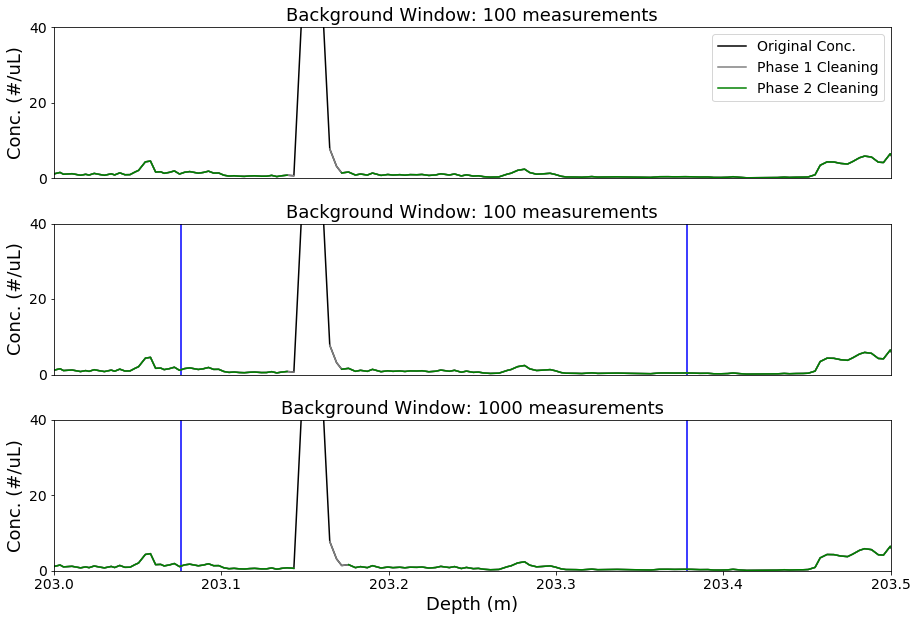

In [65]:
# PARTICLE CONCENTRATION OUTLIER REMOVAL WITH DIFFERENT BACKGROUNDS
# BY DEPTH
# 680-684 for big event
xmin = 203
xmax = 203.5
ymin = 0
ymax = 40

fig = plt.figure(figsize = (15,10));
ax1 = fig.add_subplot(311);
ax2 = fig.add_subplot(312);
ax3 = fig.add_subplot(313);
fig.subplots_adjust(hspace = 0.3)

ax1.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax1.plot(cfa_holocene['Depth (m)'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax1.plot(scenario1['Depth (m)'], scenario1['Sum 1.1-10'], color = 'green');
ax1.set_ylabel('Conc. (#/uL)', fontsize = 18);
mylabels = ['Original Conc.', 'Phase 1 Cleaning','Phase 2 Cleaning', 'Volcanic Event'];
ax1.legend(mylabels, fontsize = 14);
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, ymax);
ax1.set_title('Background Window: ' + str(window1) + ' measurements', fontsize = 18);
ax1.axes.get_xaxis().set_visible(False);
ax1.set_yticks([0, 20, 40]);
ax1.tick_params(labelsize = 14);

ax2.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax2.plot(cfa_holocene['Depth (m)'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax2.plot(scenario2['Depth (m)'], scenario2['Sum 1.1-10'], color = 'green');
ax2.vlines(holocene_volc['Core Depth (m)'], 0, 700000, color = 'blue')    
ax2.set_ylabel('Conc. (#/uL)', fontsize = 18);
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(ymin, ymax);
ax2.set_title('Background Window: ' + str(window2) + ' measurements', fontsize = 18);
ax2.axes.get_xaxis().set_visible(False);
ax2.set_yticks([0, 20, 40]);
ax2.tick_params(labelsize = 14);

ax3.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax3.plot(cfa_holocene['Depth (m)'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax3.plot(scenario3['Depth (m)'], scenario3['Sum 1.1-10'], color = 'green');
ax3.vlines(holocene_volc['Core Depth (m)'], 0, 700000, color = 'blue')    
ax3.set_ylabel('Conc. (#/uL)', fontsize = 18);
ax3.set_xlabel('Depth (m)', fontsize = 18);
ax3.set_xlim(xmin, xmax);
ax3.set_ylim(ymin, ymax);
ax3.set_title('Background Window: ' + str(window3) + ' measurements', fontsize = 18);
ax3.tick_params(labelsize = 14);
ax3.set_yticks([0, 20, 40]);

#plt.savefig('../Figures/682 event volcs preserved.png')

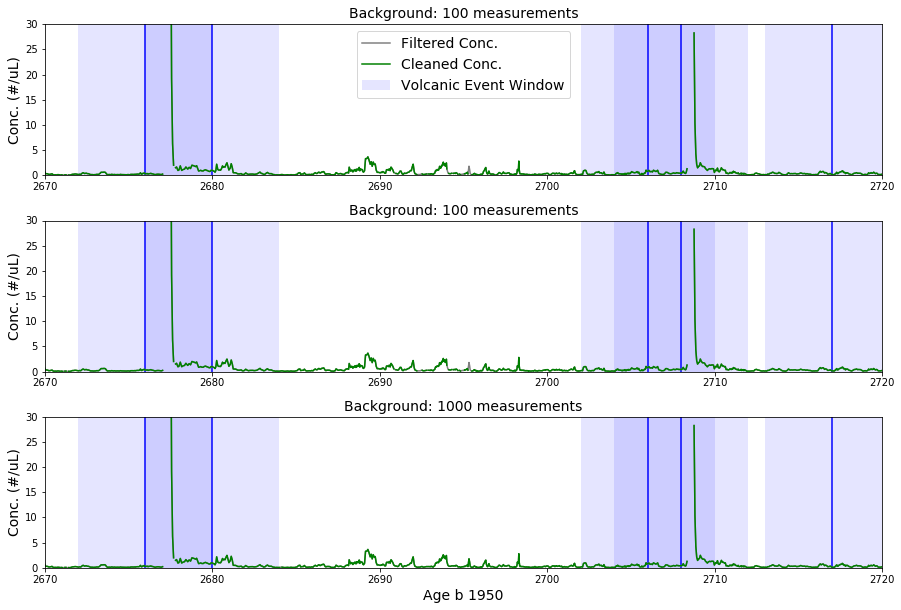

In [71]:
# PARTICLE CONCENTRATION OUTLIER REMOVAL WITH DIFFERENT BACKGROUNDS
# BY AGE 

# Age 9240-9480 ~= Depth 680-690
# 975 to 995 example of good volcanic preservation
xmin = 2670
xmax = 2720
ymin = 0
ymax = 30

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
fig.subplots_adjust(hspace = 0.3)

ax1.plot(cfa_holocene['Age b 1950'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax1.plot(scenario1['Age b 1950'], scenario1['Sum 1.1-10'], color = 'green');

for start in holocene_volc['Buffered Start Year (b1950)']:
    end = start - 8
    midpoint = (start + end) / 2
    ax1.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
    ax1.vlines(midpoint, 0, 700000, color = 'blue')
    
ax1.set_ylabel('Conc. (#/uL)', fontsize = 14);
mylabels = ['Filtered Conc.', 'Cleaned Conc.', 'Volcanic Event Window']
ax1.legend(mylabels, fontsize = 14)
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, ymax);
ax1.set_title('Background: ' + str(window1) + ' measurements', fontsize = 14);


ax2.plot(cfa_holocene['Age b 1950'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax2.plot(scenario2['Age b 1950'], scenario2['Sum 1.1-10'], color = 'green');

for start in holocene_volc['Buffered Start Year (b1950)']:
    end = start - 8
    midpoint = (start + end) / 2
    ax2.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
    ax2.vlines(midpoint, 0, 700000, color = 'blue')
    
ax2.set_ylabel('Conc. (#/uL)', fontsize = 14);
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(ymin, ymax);
ax2.set_title('Background: ' + str(window2) + ' measurements', fontsize = 14);


ax3.plot(cfa_holocene['Age b 1950'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax3.plot(scenario3['Age b 1950'], scenario3['Sum 1.1-10'], color = 'green');

for start in holocene_volc['Buffered Start Year (b1950)']:
    end = start - 8
    midpoint = (start + end) / 2
    ax3.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
    ax3.vlines(midpoint, 0, 700000, color = 'blue')
    
ax3.set_ylabel('Conc. (#/uL)', fontsize = 14);
ax3.set_xlabel('Age b 1950', fontsize = 14);
ax3.set_xlim(xmin, xmax);
ax3.set_ylim(ymin, ymax);
ax3.set_title('Background: ' + str(window3) + ' measurements', fontsize = 14);

#plt.savefig('../Figures/Another example, preserved.png')

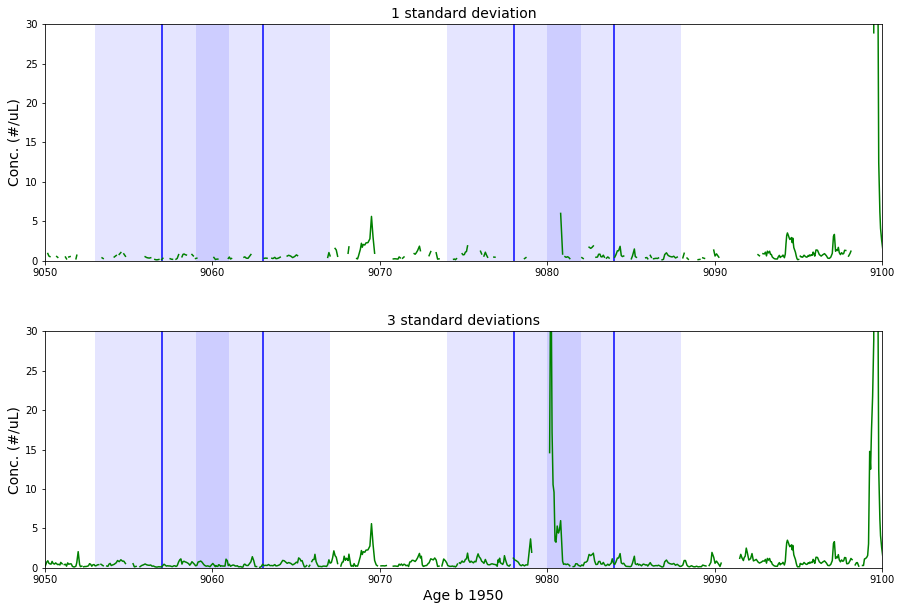

In [48]:
# PARTICLE CONCENTRATIONS W/ DIFFERENT STANDARD DEVIATION THRESHOLDS
# BY AGE

# Age 9240-9480 ~= Depth 680-690
# 975 to 995 example of good volcanic preservation

xmin = 9050
xmax = 9100
ymin = 0
ymax = 30

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.subplots_adjust(hspace = 0.3)

#ax1.plot(cfa_holocene['Age b 1950'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax1.plot(scenario2['Age b 1950'], scenario2['Sum 1.1-10'], color = 'green');

for start in holocene_volc['Buffered Start Year (b1950)']:
    end = start - 8
    midpoint = (start + end) / 2
    ax1.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
    ax1.vlines(midpoint, 0, 700000, color = 'blue')
    
ax1.set_ylabel('Conc. (#/uL)', fontsize = 14);
#mylabels = ['Filtered Conc.', 'Cleaned Conc.', 'Volcanic Event']
#ax1.legend(mylabels, fontsize = 14)
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, ymax);
ax1.set_title('1 standard deviation', fontsize = 14);

#ax2.plot(cfa_holocene['Age b 1950'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax2.plot(scenario5['Age b 1950'], scenario5['Sum 1.1-10'], color = 'green');

for start in holocene_volc['Buffered Start Year (b1950)']:
    end = start - 8
    midpoint = (start + end) / 2
    ax2.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
    ax2.vlines(midpoint, 0, 700000, color = 'blue')
    
ax2.set_ylabel('Conc. (#/uL)', fontsize = 14);
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(ymin, ymax);
ax2.set_xlabel('Age b 1950', fontsize = 14);
ax2.set_title('3 standard deviations', fontsize = 14);

#plt.savefig('../Figures/Min&Max2, not preserving.png')

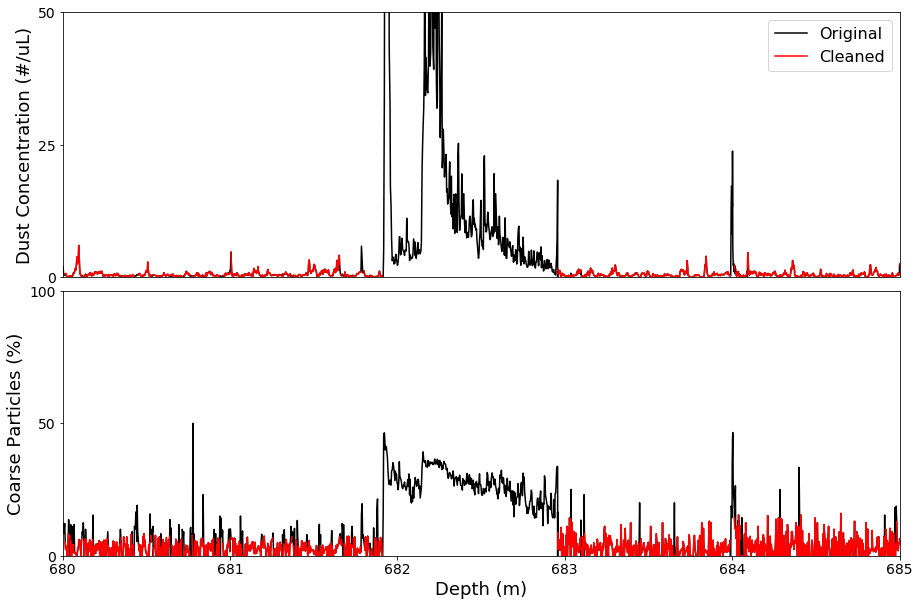

In [11]:
# BEFORE & AFTER PLOTS OF PARTICLE CONCENTRATION AND CPP

xmin = 680
xmax = 685
ymin = 0
ymax = 100

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.subplots_adjust(hspace = 0.05)


ax1.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax1.plot(scenario2['Depth (m)'], scenario2['Sum 1.1-10'], color = 'red')
ax1.set_ylabel('Dust Concentration (#/uL)', fontsize = 18);
mylabels = ['Original', 'Cleaned'];
ax1.legend(mylabels, fontsize = 16);
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, 50);
ax1.tick_params(labelsize = 14);
ax1.set_yticks([0, 25, 50]);
ax1.axes.get_xaxis().set_visible(False)

ax2.plot(original_cfa['Depth (m)'], original_cfa['CPP'], c = 'black');
ax2.plot(scenario2['Depth (m)'], scenario2['CPP'], color = 'red')
ax2.set_ylabel('Coarse Particles (%)', fontsize = 18);
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(0, 80);
ax2.tick_params(labelsize = 14);
ax2.set_yticks([0, 50, 100]);
ax2.set_xlabel('Depth (m)', fontsize = 18);

#plt.savefig('../Figures/Example for 203.2.png')

In [ ]:
# BEFORE & AFTER CONCENTRATION & CPP PLOTS, WITH STANDARD DEVIATIONS, TIE POINTS, & CORE BREAKS

#Before & after conc. & cpp plots

# Choose interval of interest
xmin = 240
#xmax = xmin + 2
xmax = 242
label = xmin

fig = plt.figure(figsize = (15,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax1.plot(original_cfa['Depth (m)'], original_sums.rolling(100).std(), c = 'red')
# To plot volcanic ties (bottom depths)
ax1.vlines(all_ties['Bot D (m)'], 0, 700000, color = 'blue')
# To plot core break ranges
ax1.vlines(breaks['3 cm Range (m)'], 0, 700000, color = 'grey')
mylabels = ['Conc.', 'St. Dev','Tie Points','Core Break Ranges']
ax1.legend(labels = mylabels)
ax1.set_ylabel('Original Conc. (# / uL)', fontsize = 12);
ax1.set_ylim(0, 20);
ax1.set_yticks([0, 10, 20]);
ax1.set_xlim(xmin,xmax);

ax2.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'], c = 'black');
ax2.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'].rolling(100).std(), c = 'red');
# To plot volcanic ties (bottom depths)
ax2.vlines(all_ties['Bot D (m)'], 0, 700000, color = 'blue')
# To plot core break ranges
ax2.vlines(breaks['3 cm Range (m)'], 0, 700000, color = 'grey')
ax2.set_ylabel('New Conc. (# / uL)', fontsize = 12);
ax2.set_ylim(0, 20);
ax2.set_yticks([0, 10, 20])
ax2.set_xlim(xmin,xmax);
ax2.axes.get_xaxis().set_visible(False);

ax3.plot(original_cfa['Depth (m)'], original_cfa['CPP'], c = 'black');
ax3.plot(original_cfa['Depth (m)'], original_cfa['CPP'].rolling(100).std(), c = 'green')
ax3.set_ylabel('Original CPP (%)', fontsize = 12);
ax3.set_ylim(0, 40);
ax3.set_xlim(xmin,xmax);
ax3.set_yticks([0, 20, 40])
ax3.axes.get_xaxis().set_visible(False);

ax4.plot(cfa['Depth (m)'], cfa['CPP'], c = 'black');
ax4.plot(cfa['Depth (m)'], cfa['CPP'].rolling(100).std(), c = 'green');
ax4.set_ylabel('New CPP (%)', fontsize = 12);
ax4.set_ylim(0, 40)
ax4.set_yticks([0, 20, 40])
ax4.set_xlim(xmin,xmax);
ax4.set_xlabel('Depth (m)', fontsize = 12);

#plt.savefig('../Figures/Cleaned_' + str(label) + '.png')

In [109]:
# WHY ARE THESE ZEROES HERE IN THE RAW, UNFILTERED DATA?
# MY RAW_CFA FILE IS THE SAME. ARE THESE ZEROES REAL?
# Happens right at 20,000 years ago
# Melt issues here in melt log. What to do when system crashed, or Abakus wasn't working?
# Why did phase 1 remove these data? Did it actually?

original_cfa.loc[286510:286520, :]

,Depth (m),Flow Rate,ECM,1,1.1,1.2,1.3,1.4,1.5,1.6,...,5.1,5.7,6.4,7.2,8.1,9,10,12,Original Depth (m),CPP
286510,1081.721263,2150.0,2.25,5.581395,2.790698,1.364341,0.868217,0.682171,0.558140,0.589147,...,0.049612,0.021705,0.006202,0.000000,0.000000,0.000000,0.0,0.0,1081.7110,1.445466
286511,1081.724255,1589.0,2.33,23.285085,11.327879,5.726872,3.775960,2.706104,2.517307,2.454374,...,0.327250,0.113279,0.062933,0.012587,0.006293,0.000000,0.0,0.0,1081.7140,2.272445
286512,1081.727247,2237.8,2.35,20.718400,10.562322,5.321785,3.981183,2.924951,2.518708,2.274962,...,0.341244,0.138123,0.032499,0.008125,0.000000,0.012187,0.0,0.0,1081.7170,2.354178
286513,1088.126501,-40.6,0.05,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,1088.1350,NaN
286514,1088.129594,3248.6,1.70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1381,NaN
286515,1088.132586,2543.8,1.78,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1411,NaN
286516,1088.135679,2421.2,1.85,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1442,NaN
286517,1088.138671,2746.2,2.19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1472,NaN
286518,1088.141764,2115.8,2.17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1503,NaN
286519,1088.144756,2286.0,2.08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1533,NaN


In [25]:
cfa.loc[286510:286520, 'Depth (m)':'1.2']

,Depth (m),Flow Rate,ECM,1,1.1,1.2
286510,1081.721263,2150.0,2.25,5.581395,2.790698,1.364341
286511,1081.724255,1589.0,2.33,23.285085,11.327879,5.726872
286512,1081.727247,2237.8,2.35,20.718400,10.562322,5.321785
286513,NaN,NaN,NaN,NaN,NaN,NaN
286514,1088.129594,3248.6,1.70,0.000000,0.000000,0.000000
286515,1088.132586,2543.8,1.78,0.000000,0.000000,0.000000
286516,1088.135679,2421.2,1.85,0.000000,0.000000,0.000000
286517,1088.138671,2746.2,2.19,0.000000,0.000000,0.000000
286518,1088.141764,2115.8,2.17,0.000000,0.000000,0.000000
286519,1088.144756,2286.0,2.08,0.000000,0.000000,0.000000


In [39]:
cfa.loc[287050:287052, 'Depth (m)':'1.2']

,Depth (m),Flow Rate,ECM,1,1.1,1.2
287050,1090.227274,2482.6,3.38,0.00000,0.00000,0.000000
287051,1090.229271,2261.2,2.83,0.00000,0.00000,0.000000
287052,1090.232366,2671.6,2.54,25.20806,11.24082,5.307913


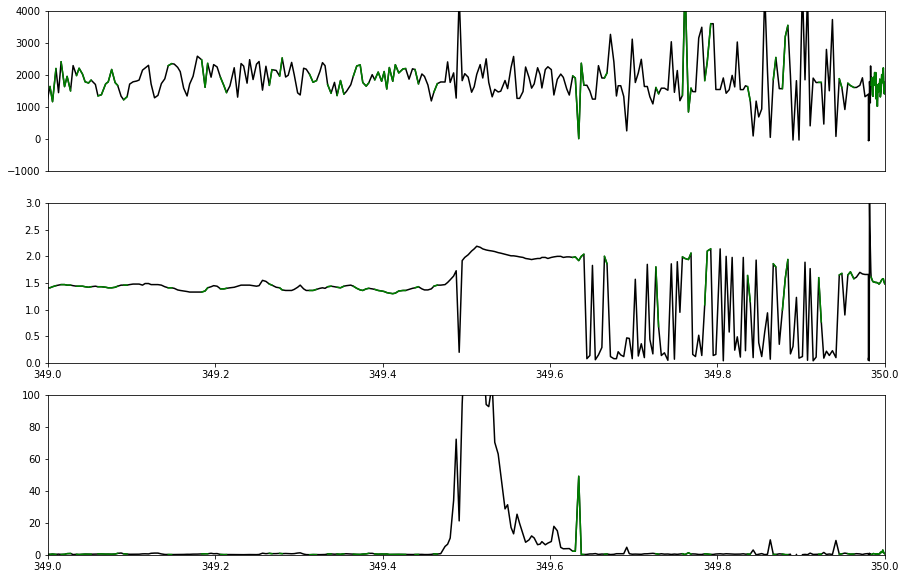

In [26]:
# Plotting real dust events
xmin = 349
xmax = 350

fig = plt.figure(figsize = (15,10));
ax1 = fig.add_subplot(311);
ax2 = fig.add_subplot(312);
ax3 = fig.add_subplot(313);
#fig.subplots_adjust(hspace = 0.1);

ax1.plot(original_cfa['Depth (m)'], original_cfa['Flow Rate'], c = 'black');
ax1.plot(cfa['Depth (m)'], cfa['Flow Rate'], c = 'green');
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(-1000,4000)
ax1.axes.get_xaxis().set_visible(False);

ax2.plot(original_cfa['Depth (m)'], original_cfa['ECM'], c = 'black');
ax2.plot(cfa['Depth (m)'], cfa['ECM'], c = 'green');
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(0, 3);
#ax2.set_yticks([0,50,100])
#ax2.set_xticks([0, 400, 800, 1200, 1600])
#ax2.set_ylabel('Coarse Particles (%)', fontsize = 18);
#ax2.tick_params(labelsize = 14);

ax3.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax3.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'], c = 'green');
ax3.set_ylim(0,100)
ax3.set_xlim(xmin, xmax);
#plt.savefig('../Figures/Original Time Series.png')


In [9]:
cfa.head()

,Depth (m),Flow Rate,ECM,1,1.1,1.2,1.3,1.4,1.5,1.6,...,7.2,8.1,9,10,12,Original Depth (m),Break?,New Break?,Age b 1950,CPP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN


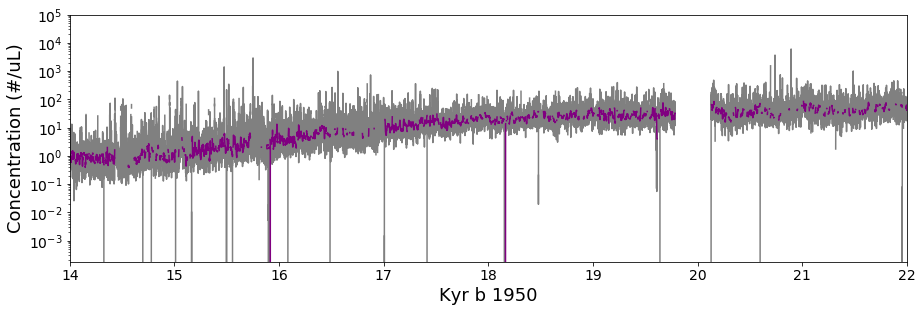

In [20]:
# 
xmin = 14
xmax = 22

age_kyr = cfa['Age b 1950'].div(1000)
running_med_conc = cfa['Sum 1.1-10'].rolling(50, min_periods = 50).median()
running_med_cpp  = cfa['CPP'].rolling(50).median()

fig = plt.figure(figsize = (15,10));
ax1 = fig.add_subplot(211);
#ax2 = fig.add_subplot(212);
#fig.subplots_adjust(hspace = 0.1);

ax1.plot(age_kyr, cfa['Sum 1.1-10'], c = 'grey');
ax1.plot(age_kyr, running_med_conc, c = 'purple')
ax1.set_xlim(xmin, xmax);
ax1.tick_params(labelsize = 14);
#ax1.set_yticks([0, 5000, 10000]);
#ax1.set_ylim(-1000, 10000)
ax1.set_yscale("log")
ax1.set_ylabel('Concentration (#/uL)', fontsize = 18);
#ax1.axes.get_xaxis().set_visible(False);
#ax1.set_xticks([0, 10, 16, 18, 20, 30, 40, 50])
ax1.set_xlabel('Kyr b 1950', fontsize = 18);

#ax2.plot(age_kyr, cfa['CPP'], c = 'grey');
#ax2.plot(age_kyr, running_med_cpp, c = 'purple')
#ax2.set_xlim(xmin, xmax);
#ax2.set_ylim(0,50);
#ax2.set_ylim(0, 100);
#ax2.set_yticks([0,50,100])
#ax2.set_xticks([0, 10, 16, 18, 20, 30, 40, 50])
#ax2.set_ylabel('Coarse Particles (%)', fontsize = 18);
#ax2.tick_params(labelsize = 14);
#ax2.set_xlabel('Kyr b 1950', fontsize = 18);

#plt.savefig('../Figures/Missing LGM data.png')